# HW 5 - Page Rank (Shishir Agarwal)
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

### Run the next cell to create your directory in dbfs
You do not need to understand this scala snippet. It simply dynamically fetches your user directory name so that any files you write can be saved in your own directory.

In [0]:
# RUN THIS CELL AS IS
# This code snippet reads the user directory name, and stores is in a python variable.
# Next, it creates a folder inside your home folder, which you will use for files which you save inside this notebook.
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
hw5_path = userhome + "/HW5/" 
hw5_path_open = '/dbfs' + hw5_path.split(':')[-1] # for use with python open()
dbutils.fs.mkdirs(hw5_path)

dbfs:/user/shishir.agarwal@ischool.berkeley.edu
Out[635]: True

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[636]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/5d74113d-bae1-4f39-81a1-b158b698ea13/,5d74113d-bae1-4f39-81a1-b158b698ea13/,0
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
# RUN THIS CELL AS IS - A test to make sure your directory is working as expected.
# You should see a result like:
# dbfs:/user/youremail@ischool.berkeley.edu/HW5/test.txt
dbutils.fs.put(hw5_path+'test.txt',"hello world",True)
display(dbutils.fs.ls(hw5_path))


Wrote 11 bytes.

path,name,size
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW5/Q8_top_20.txt,Q8_top_20.txt,730
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW5/test.txt,test.txt,11


In [0]:
sc = spark.sparkContext
spark

Out[639]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 spark://10.99.233.159:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ Airline flight delay dataset will be appropriate to represent as graph. In this case the airport will represent the nodes and flight connection between 2 airport will represent the edges. This graph will be a directed graph which means a flight from airport A to airport B is different to flight from airport B to airport A. Thus, the direction of the flight is represented by the directed edge. The average in-degree of a node will represent how important is the airport in the network. Thus, one can use the page rank algorithm to assess which airports are most influential in the network. 

> __b)__ The graphs are uniquely challenging to work with the map-reduce paradigm due to two reasons. The first being majority of the graphs are sparse and holding it memory is untaneable especially when processing graphs that have billions of nodes. The second being majority of algorithms that work on graph datastructure are iterative and sequential in nature which means one needs to share information from one iteration with the next which is difficult to achieve in MapReduce framework. Also it means every iteration has a shuffle operation that can be expensive and can come in the way of scalability. 

> __c)__ Dijskra's algorithm is used to find the shortest path from single node to all the nodes in a graph. The key to Dijkstra’s algorithm is the priority queue that maintains a globally- sorted list of nodes by distance that is shared from one iteration to another. This is not possible in MapReduce, as the programming model does not provide a mechanism for exchanging global data. Thus, because of the sequential nature of the algorithm and sharing global data from one iteration to another, it is hard to paralezie this in the mapreduce framework 

> __d)__ Thus instead of maintaining a global priority queue, parallel breadth-first search is an iterative algorithm, where each iteration corresponds to a MapReduce job. The first time we run the algorithm, we “discover” all nodes that are connected to the source. The second iteration, we discover all nodes connected to those, and so on. With each iteration we pass the graph structure from one iteration to the next. This is accomplished by emitting the node data structure. In the reducer, we distinguish the node data structure from distance values and update the minimum distance in the node data structure. The parallel breadth-first search in MapReduce is a brute force approach that wastes a lot of time performing computations whose results are discarded.

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ The graph described relatively speaking is a sparse graph because each node is not connected to all other nodes. If the graph is dense then one can use the matrix representation. However if the graph is sparse one can use the list representation. This allows for more efficent use of memory.

> __b)__ This graph is a directed graph. The adjency matrix for undirected graph is symmeterical while adjency matrix for undirceted graph may not be symmeterical.

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for edge in graph['edges']:
      adj_matr.loc[edge[0],edge[1]] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for edge in TOY_GRAPH['edges']:
      adj_list[edge[0]].append(edge[1])
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ PageRank is a measure of web page quality based on the structure of the hyperlink graph. It is a measure of how frequently a page would be encountered by the surfer. In terms of Markov chain terminology, PageRank is a probability distribution over nodes in the graph representing the likelihood that a random walk over the link structure will arrive at a particular node. Nodes that have high in-degrees tend to have high PageRank values, as well as nodes that are linked to by other nodes with high PageRank values.

> __b)__ A Markov chain is a  system that undergoes transitions from one state to another, between a finite number of possible states. Markov property is when the next state in the Markov chain depends only on the  current state and not on the sequence of events  that preceded it. What it means is Page Rank is a function of how pages are linked together in form of a web graph and more you visit a certain web page higher is the probability of being in that state.

> __c)__ In context of PageRank, the states referes to different web pages within the world wide web and the transition matrix refers to how these pages are linked with one another. Because there are more than billion pages on the world wide web the transition matrix will consists to more than 1 billion rows and more than 1 billion columns. Thus, transition matrix will be very large.

> __d)__ The right stochastic matrix is a square matrix that describe the transitions of a Markov chain. Each of its entries in the right stochastic matrix is a nonnegative real number representing a probability and the sum of all rows add upto 1.

> __e)__ It takes about 20 iterations to converge to a steady state. Node E is most central with highest rank and it matches the intuition because it is mostly highly interconnected with other node relative to other nodes. It has total of 5 edges of which 2 are incoming and 3 are outgoing.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
#transition_matrix = None # replace with your code
transition_matrix = TOY_ADJ_MATR.divide(TOY_ADJ_MATR.sum(axis=1), axis=0)
################ (END) YOUR CODE #################
print(transition_matrix)

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    state_vector = xInit
    for i in range(nIter):
      #state_vector = state_vector.dot(tMatrix).dot(tMatrix)
      tMatrix = tMatrix.dot(tMatrix)
      state_vector = state_vector.dot(tMatrix)
      if verbose:
        print(f'Step{i}: Sum:{sum(state_vector):.2f}')
        print([f'{f:.8f}' for f in state_vector])
    ################ (END) YOUR CODE #################
    return state_vector

java.lang.RuntimeException: abort: DriverClient destroyed
	at com.databricks.backend.daemon.driver.DriverClient.$anonfun$poll$3(DriverClient.scala:381)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at com.databricks.threading.NamedExecutor$$anon$2.$anonfun$run$1(NamedExecutor.scala:345)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:240)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:235)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:232)
	at com.databricks.threading.NamedExecutor.withAttributionContext(NamedExecutor.scala:275)
	at com.databricks.threading.NamedExecutor$$anon$2.run(NamedExecutor.scala:345)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, True) # part e - compute the steady state using the transition matrix
states

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __a)__ We observe that probability does not converge to steady state. It keeps decreasing until the vector nears zero probability. 

> __b)__ We have a dangling node __E__ which has incoming edges from node __B__ and node __C__ but no outgoing edges. After each iteration we could take the probability for node __E__ and distribute it equally among other nodes.

> __c)__ A graph is irrudicible if one can get from one node to every other node in the graph. On the web there are pages that do not link to other pages and the only way to get to those specific pages is by typing the http address directly. Few of these pages are linked together but many are not. Thus, given we have more than billion pages, chances are there are pages we cannot get to just by surfing. Thus, I would say the webgraph is not naturally irrudicible.

> __d)__ A graph is aperiodic if you do not oscilitate from one state to another while traversing the graph. I do think the web graph is naturally aperiodic because there are many pages that link back to themselves and in a Markov chain even if 1 page links back to itself then the entire chain is aperiodic.

> __e)__ Teleportation which is very natural during random surfing gurantees aperiodicity and irruducibility. One can teleport easily from any browser via typing in a URL to a web page that they want to teleport.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

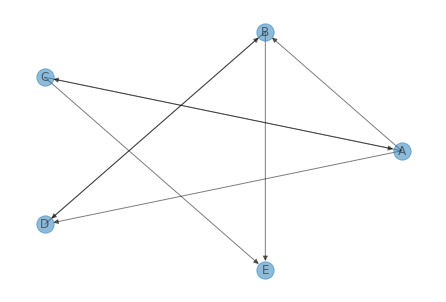

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)
print(TOY2_ADJ_MATR)
TOY2_transition_matrix = TOY2_ADJ_MATR.divide(TOY2_ADJ_MATR.sum(axis=1), axis=0)
TOY2_transition_matrix = TOY2_transition_matrix.fillna(0)
print(TOY2_transition_matrix)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, TOY2_transition_matrix, 10, verbose = True)
states
################ (END) YOUR CODE #################

A B C D E
A 0 1 1 1 0
B 0 0 0 1 1
C 1 0 0 0 1
D 0 1 0 0 0
E 0 0 0 0 0
 A B C D E
A 0.0 0.333333 0.333333 0.333333 0.0
B 0.0 0.000000 0.000000 0.500000 0.5
C 0.5 0.000000 0.000000 0.000000 0.5
D 0.0 1.000000 0.000000 0.000000 0.0
E 0.0 0.000000 0.000000 0.000000 0.0
Step0: Sum:1.00
['0.16666667', '0.33333333', '0.00000000', '0.16666667', '0.33333333']
Step1: Sum:0.25
['0.00462963', '0.12037037', '0.00000000', '0.06018519', '0.06481481']
Step2: Sum:0.02
['0.00000357', '0.00780893', '0.00000000', '0.00390446', '0.00390804']
Step3: Sum:0.00
['0.00000000', '0.00003052', '0.00000000', '0.00001526', '0.00001526']
Step4: Sum:0.00
['0.00000000', '0.00000000', '0.00000000', '0.00000000', '0.00000000']
Step5: Sum:0.00
['0.00000000', '0.00000000', '0.00000000', '0.00000000', '0.00000000']
Step6: Sum:0.00
['0.00000000', '0.00000000', '0.00000000', '0.00000000', '0.00000000']
Step7: Sum:0.00
['0.00000000', '0.00000000', '0.00000000', '0.00000000', '0.00000000']
Step8: Sum:0.00
['0.00000000', '0.00000000', '0.00000000', '0.00000000', '0.00000000']
Step9: Sum:0.00
['0.00000000', '0.00000000', '0.00000000', '0.00000000', '0.00000000']
Out[331]: array([0.00000000e+000, 1.11253693e-308, 0.00000000e+000, 5.56268465e-309,
 5.56268465e-309])

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/5d74113d-bae1-4f39-81a1-b158b698ea13/,5d74113d-bae1-4f39-81a1-b158b698ea13/,0
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[335]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(50)

Out[336]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15',
 '!!! Chk Chk Chk\t11\t1\t0',
 '!!!\t12\t182\t67',
 '!!!Fuck You!!! And Then Some\t13\t1\t0',
 '!!!Fuck You!!! and Then Some\t14\t6\t0',
 '!!!Fuck You!!!\t15\t8\t1',
 '!!\t16\t1\t15',
 '!!Destroy-Oh-Boy!!\t17\t5\t33',
 '!!Fuck you!!\t18\t0\t2',
 '!!M\t19\t0\t1',
 '!\t20\t35\t0',
 '!10 Show\t21\t1\t0',
 '!=\t22\t1\t0',
 '!A310Emu\t23\t1\t0',
 '!Action Pact!\t24\t9\t10',
 '!Aiboforcen\t25\t1\t0',
 '!Alabadle!\t26\t2\t0',
 '!Arriba! La Pachanga\t27\t0\t14',
 '!Bang! TV\t28\t1\t0',
 '!Bang!\t29\t14\t0',
 '!Bang!#Funking Conservatory\t30\t3\t0',
 '!Corre!\t31\t1\t0',
 '!Deladap\t32\t1\t0',
 '!Earshot\t33\t3\t0',
 '!GAG!\t34\t1\t0',
 '!Gã!ne\t35\t0\t1',
 '!HERO\t36\t1\t0',
 '!Hero (album)\t37\t7\t40',
 '!Hero\t38\t20\t51',
 '!Huns\t39\t1\t0',
 '!K7 Records\t40\t45\t0',
 '!K7\t41\t40\t1',
 '!Ka-Boom¡ Estudio\t42\t1\t0',
 '!Karapuri!\t43\t1\t0',
 '!Karas Region\t44\t1\t1',
 '!Kheis Local Municipality\t45\t7\t1',
 '!Kora language\t46\t1\t0',
 '!Kora\t47\t2\t0',
 '!Kung San\t48\t4\t0',
 '!Kung language\t49\t32\t71',
 '!Kung people\t50\t36\t1']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(100)

Out[337]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}",
 "3165\t{'7352374': 1}",
 "3306\t{'9002430': 1}",
 "3683\t{'12394205': 1}",
 "3865\t{'677882': 1, '5348236': 1, '3868': 2, '3354266': 1, '9655336': 1, '1218598': 1, '3861': 2, '11950526': 1, '11457951': 1, '9731855': 1, '3977737': 1, '840036': 1, '8401581': 1, '1614968': 3, '7653909': 1, '3440693': 1, '3440694': 4, '6507723': 1, '4368317': 1, '13727203': 1, '1793966': 1, '14227632': 1, '6848410': 1, '4487113': 1, '5952350': 1, '6229891': 2, '11243032': 8, '1070634': 1, '3870': 1, '861366': 3, '12837116': 1, '12867472': 2, '11243035': 1, '10500074': 1, '5952616': 1}",
 "4016\t{'14758366': 1}",
 "4078\t{'12473070': 1}",
 "4084\t{'1239703': 1}",
 "4093\t{'13079602': 1}",
 "4104\t{'14749047': 1}",
 "4935\t{'4378841': 1}",
 "5175\t{'14112408': 1, '12744717': 1, '8409098': 1, '15113675': 1, '5114960': 1, '14490488': 1, '8504508': 1, '1197317': 1, '1182188': 1, '4198751': 1, '4719196': 1, '9472215': 1, '4204755': 1, '14466139': 1, '11285108': 1, '11683114': 1, '9306355': 1, '7369423': 1, '1947337': 1, '8077159': 3}",
 "5378\t{'12838673': 1}",
 "5618\t{'5846955': 1, '2444575': 1, '14143166': 1, '9567158': 1, '8169888': 1, '14947236': 1, '576768': 1, '1970330': 1, '8150169': 1, '14382339': 1, '13162272': 1, '5290702': 1, '2943488': 1, '9115045': 1, '576815': 1}",
 "5923\t{'5565904': 1, '9355455': 1, '4952509': 1, '14363688': 1}",
 "6669\t{'14920333': 1, '15135531': 2, '14954634': 1, '8714183': 2, '10923155': 1, '9765257': 2, '15036383': 1, '14920387': 1, '14494658': 1, '5081567': 1, '4659409': 1, '6825601': 1, '14631937': 1, '10371444': 2, '1452539': 1, '14804674': 1, '9346940': 1, '2651136': 2, '14663615': 1, '15040377': 2, '3549665': 1, '14618056': 1, '14626767': 1, '7284281': 1, '6825678': 1, '2941518': 1, '14957419': 2, '10169151': 1, '9417803': 1, '7284282': 1}",
 "8133\t{'14571565': 1, '14677501': 1, '10581811': 1, '14562448': 1}",
 "8157\t{'14920333': 1, '7362807': 2, '14503688': 1, '14920363': 1, '14503665': 1, '13335572': 2, '1446779': 1}",
 "9060\t{'14631937': 1, '13176094': 1, '14804674': 1, '6825601': 1, '7177388': 1, '6825678': 1, '1452570': 1, '5696174': 1, '1452539': 1, '8347372': 2, '15135531': 1, '14957419': 2, '14626767': 1}",
 "9734\t{'14794336': 1, '15149508': 1, '8714183': 1, '530737': 1, '10923155': 1, '15036383': 1, '5081567': 1, '14478868': 1, '7878620': 1, '6825601': 1, '14631937': 1, '2438135': 1, '1452539': 2, '2321858': 1, '11550186': 1, '499600': 1, '14570120': 1, '14804674': 1, '3040654': 1, '15031448': 1, '3549665': 1, '14659306': 1, '14626767': 1, '14590551': 1, '7177387': 1, '6825678': 1, '14495387': 1, '13176094': 1, '13176095': 1, '15165908': 1}",
 "11457\t{'14954575': 1, '9346940': 1, '14631937': 1, '5572514': 1, '14920411': 1, '15010519': 1, '2651136': 2, '1452539': 1, '6403957': 2, '15135531': 1, '8544459': 1, '3477610': 2}",
 "11542\t{'4951913': 1, '14873345': 1, '14503665': 1, '11790126': 1, '14238652': 1}",
 "12250\t{'5931264': 1, '6281218': 1, '11280264': 1, '7048795': 1, '12372909': 2, '14848107': 1, '14920305': 1, '14983274': 1, '1452539': 3, '14503688': 1, '6847526': 1, '9157132': 1, '4093678': 2, '13677087': 1, '8249460': 1, '11555168': 1, '1

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The raw data is in the text format and represents the adjacency list. The first value is the source node. The second part consists of list of target node and the weight of the edge from source to target.   

> __b)__ The total number of records provide number of source nodes however it does not provide all the target nodes. Thus, if we have source node that is connected to a dangling target, the total number of records will be less than or equal to toatl number of nodes.

> __d)__ The number of dangling node will be __=__ (source nodes + target nodes) - (source nodes) = 15,192,277 - 5,781,290 = 9,410,987

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def nodeCount(line):
      parta, partb = line.split('\t')
      dictionary = eval(partb)
      source = int(parta)
      for key, value in dictionary.items():
        yield int(key)
      yield source  
    totalCount = dataRDD.flatMap(nodeCount).distinct().count()
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 4.342552900314331 seconds.
Total Nodes: 11

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 176.0851752758026 seconds.
Total Nodes: 15192277

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ The information about the out degree is used to distribute the probability of the specific node to other nodes that are outbound directed. This distribution lets PageRank utilize the Markov chain to calculate the steady state probability of each node which is then used to rank order the web pages 

> __c)__ If the node out-degree is 0, it just means it is a dangling node. There is no outbound directed edge from this node. For dangling nodes we take the probability of the dangling node and distribute it equally among other nodes to avoid non-convergence

In [0]:
def parse(line):
  node, edges = line.split('\t')
  yield (node, ast.literal_eval(edges))

In [0]:
testRDD.flatMap(parse).collect()

Out[343]: [('2', {'3': 1}),
 ('3', {'2': 2}),
 ('4', {'1': 1, '2': 1}),
 ('5', {'4': 3, '2': 1, '6': 1}),
 ('6', {'2': 1, '5': 2}),
 ('7', {'2': 1, '5': 1}),
 ('8', {'2': 1, '5': 1}),
 ('9', {'2': 1, '5': 1}),
 ('10', {'5': 1}),
 ('11', {'5': 2})]

In [0]:
temp = testRDD.flatMap(parse)

In [0]:
def degree(data):
  source, edges = data
  total = sum([value for value in edges.values()])
  return (source, total,1)

In [0]:
temp.map(lambda x: (x[0],sum([value for value in x[1].values()]))).takeOrdered(10, key=lambda x: -x[1])

Out[346]: [('5', 5),
 ('6', 3),
 ('3', 2),
 ('4', 2),
 ('7', 2),
 ('8', 2),
 ('9', 2),
 ('11', 2),
 ('2', 1),
 ('10', 1)]

In [0]:
temp.map(lambda x: sum([value for value in x[1].values()])).mean()

Out[347]: 2.2

In [0]:
temp.map(lambda x: sum([value for value in x[1].values()])).takeSample(False, 5, 1)

Out[348]: [2, 1, 2, 2, 2]

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    ############## YOUR CODE HERE ###############
    tempRDD = dataRDD.map(parse).cache()
    top = tempRDD.map(lambda x: (x[0],sum([value for value in x[1].values()]))).takeOrdered(10, key=lambda x: -x[1])
    avgDegree = tempRDD.map(lambda x: sum([value for value in x[1].values()])).mean()
    sampledCounts = tempRDD.map(lambda x: sum([value for value in x[1].values()])).takeSample(False, n, 1)
    ############## (END) YOUR CODE ###############
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 25.507940769195557 seconds
Average out-degree: 2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('3', 2), ('4', 2), ('7', 2), ('8', 2), ('9', 2), ('11', 2), ('2', 1), ('10', 1)]

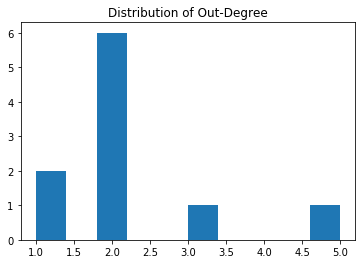

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 197.18535661697388 seconds
Average out-degree: 32.04181575392349
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]

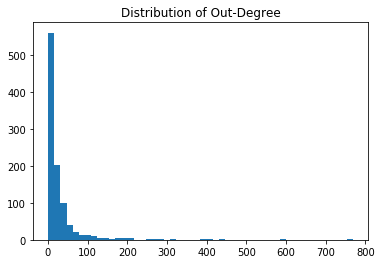

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ N is total number of wiki pages. We assume any user can start with any one of the wiki pages and initially the probability is eqully distributed among the wiki pages. Thus, surfer can start at any of the wiki pages.

> __b)__ It is better to compute N before initializing because one can use the value of N to initialize with 1/N probability

In [0]:
x = (1,'a')
y = (2,'b')
y[0]

Out[354]: 2

In [0]:
def parse(line):
  node, edges = line.split('\t')
  yield (node, ast.literal_eval(edges))
def nodes(data):
  source, edges = data
  connect = len(edges)
  yield(source, (connect, edges))
  for k,v in edges.items():
    yield(k, (0, {}))
def aggnodes(x,y):
  if x[0] > y[0]:
    return x
  else:
    return y

In [0]:
testRDD.collect()

Out[356]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
testRDD.flatMap(parse).collect()

Out[357]: [('2', {'3': 1}),
 ('3', {'2': 2}),
 ('4', {'1': 1, '2': 1}),
 ('5', {'4': 3, '2': 1, '6': 1}),
 ('6', {'2': 1, '5': 2}),
 ('7', {'2': 1, '5': 1}),
 ('8', {'2': 1, '5': 1}),
 ('9', {'2': 1, '5': 1}),
 ('10', {'5': 1}),
 ('11', {'5': 2})]

In [0]:
testRDD.flatMap(parse).flatMap(nodes).collect()

Out[358]: [('2', (1, {'3': 1})),
 ('3', (0, {})),
 ('3', (1, {'2': 2})),
 ('2', (0, {})),
 ('4', (2, {'1': 1, '2': 1})),
 ('1', (0, {})),
 ('2', (0, {})),
 ('5', (3, {'4': 3, '2': 1, '6': 1})),
 ('4', (0, {})),
 ('2', (0, {})),
 ('6', (0, {})),
 ('6', (2, {'2': 1, '5': 2})),
 ('2', (0, {})),
 ('5', (0, {})),
 ('7', (2, {'2': 1, '5': 1})),
 ('2', (0, {})),
 ('5', (0, {})),
 ('8', (2, {'2': 1, '5': 1})),
 ('2', (0, {})),
 ('5', (0, {})),
 ('9', (2, {'2': 1, '5': 1})),
 ('2', (0, {})),
 ('5', (0, {})),
 ('10', (1, {'5': 1})),
 ('5', (0, {})),
 ('11', (1, {'5': 2})),
 ('5', (0, {}))]

In [0]:
testRDD.flatMap(parse).flatMap(nodes).reduceByKey(aggnodes).collect()

Out[359]: [('4', (2, {'1': 1, '2': 1})),
 ('1', (0, {})),
 ('8', (2, {'2': 1, '5': 1})),
 ('9', (2, {'2': 1, '5': 1})),
 ('10', (1, {'5': 1})),
 ('2', (1, {'3': 1})),
 ('3', (1, {'2': 2})),
 ('5', (3, {'4': 3, '2': 1, '6': 1})),
 ('6', (2, {'2': 1, '5': 2})),
 ('7', (2, {'2': 1, '5': 1})),
 ('11', (1, {'5': 2}))]

In [0]:
intcount = testRDD.flatMap(parse).flatMap(nodes).reduceByKey(aggnodes).count()
intcount

Out[360]: 11

In [0]:
testRDD.flatMap(parse).flatMap(nodes).reduceByKey(aggnodes).mapValues(lambda record: (1/intcount,record[1])).collect()

Out[361]: [('8', (0.09090909090909091, {'2': 1, '5': 1})),
 ('9', (0.09090909090909091, {'2': 1, '5': 1})),
 ('10', (0.09090909090909091, {'5': 1})),
 ('4', (0.09090909090909091, {'1': 1, '2': 1})),
 ('1', (0.09090909090909091, {})),
 ('7', (0.09090909090909091, {'2': 1, '5': 1})),
 ('2', (0.09090909090909091, {'3': 1})),
 ('5', (0.09090909090909091, {'4': 3, '2': 1, '6': 1})),
 ('11', (0.09090909090909091, {'5': 2})),
 ('3', (0.09090909090909091, {'2': 2})),
 ('6', (0.09090909090909091, {'2': 1, '5': 2}))]

In [0]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    def parse(line):
      node, edges = line.split('\t')
      yield (node, ast.literal_eval(edges))
    def nodes(data):
      source, edges = data
      connect = len(edges)
      yield(source, (connect, edges))
      for k,v in edges.items():
        yield(k, (0, {}))
    def aggnodes(x,y):
      if x[0] > y[0]:
        return x
      else:
        return y    
      
    # write your main Spark code here
    tempRDD = dataRDD.flatMap(parse).flatMap(nodes).reduceByKey(aggnodes).cache()
    intcount = tempRDD.count()
    graphRDD = tempRDD.mapValues(lambda record: (1/intcount,record[1]))
    ############## (END) YOUR CODE ##############
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 3.755289077758789 seconds.
Out[363]: [('4', (0.09090909090909091, {'1': 1, '2': 1})),
 ('1', (0.09090909090909091, {})),
 ('8', (0.09090909090909091, {'2': 1, '5': 1})),
 ('9', (0.09090909090909091, {'2': 1, '5': 1})),
 ('10', (0.09090909090909091, {'5': 1})),
 ('7', (0.09090909090909091, {'2': 1, '5': 1})),
 ('2', (0.09090909090909091, {'3': 1})),
 ('5', (0.09090909090909091, {'4': 3, '2': 1, '6': 1})),
 ('11', (0.09090909090909091, {'5': 2})),
 ('3', (0.09090909090909091, {'2': 2})),
 ('6', (0.09090909090909091, {'2': 1, '5': 2}))]

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 314.14631152153015 seconds

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('4363294', (6.582291778908455e-08, {'15054276': 1, '11877172': 1, '2761636': 1, '14829831': 1, '7068763': 1, '4561864': 1, '10931066': 1, '14541453': 1, '771965': 1, '8048075': 2, '8995845': 1, '15164531': 1, '887055': 1, '13464723': 1, '15083873': 1, '5594075': 3, '6299753': 1, '4053903': 1, '7073061': 2, '15083811': 1, '3836357': 1, '1697872': 1, '3958367': 1, '13619952': 1, '580628': 1, '5817487': 1, '8285282': 1, '6536183': 2, '2117165': 1, '8261980': 1, '14540900': 2, '7617893': 1}))]
... initialization continued: 23.997188091278076 seconds

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ Alpha is the probability of teleportation which is like typing in address of a random wiki page. 1-Alpha is the probability of surfing wiki page using a link. G is total number of nodes or wiki pages. Since we assume a surfer can start with any of the G pages we use __alpha/G__ 

> __b)__ __m__ represent the total mass from the dangling nodes. We distribute this mass among all the G nodes after every iteration.

> __c)__ The total mass after each iteration will be __1__ because it provides probability of rank for each node.

In [0]:
testGraphRDD = initGraph(testRDD)

In [0]:
testGraphRDD.collect()

Out[540]: [('8', (0.09090909090909091, {'2': 1, '5': 1})),
 ('9', (0.09090909090909091, {'2': 1, '5': 1})),
 ('10', (0.09090909090909091, {'5': 1})),
 ('4', (0.09090909090909091, {'1': 1, '2': 1})),
 ('1', (0.09090909090909091, {})),
 ('7', (0.09090909090909091, {'2': 1, '5': 1})),
 ('2', (0.09090909090909091, {'3': 1})),
 ('5', (0.09090909090909091, {'4': 3, '2': 1, '6': 1})),
 ('11', (0.09090909090909091, {'5': 2})),
 ('3', (0.09090909090909091, {'2': 2})),
 ('6', (0.09090909090909091, {'2': 1, '5': 2}))]

In [0]:
def distribute(data):
  source, payload = data
  score = payload[0]
  edges = payload[1]
  count = len(edges)
  if edges:
    weight = 0
    for k,v in edges.items():
      weight += v
    for k,v in edges.items():
      yield(k, ((score*v)/weight, {}))
  yield(source,(0, edges))

In [0]:
testGraphRDD.flatMap(distribute).collect()

Out[542]: [('2', (0.045454545454545456, {})),
 ('5', (0.045454545454545456, {})),
 ('8', (0, {'2': 1, '5': 1})),
 ('2', (0.045454545454545456, {})),
 ('5', (0.045454545454545456, {})),
 ('9', (0, {'2': 1, '5': 1})),
 ('5', (0.09090909090909091, {})),
 ('10', (0, {'5': 1})),
 ('1', (0.045454545454545456, {})),
 ('2', (0.045454545454545456, {})),
 ('4', (0, {'1': 1, '2': 1})),
 ('1', (0, {})),
 ('2', (0.045454545454545456, {})),
 ('5', (0.045454545454545456, {})),
 ('7', (0, {'2': 1, '5': 1})),
 ('3', (0.09090909090909091, {})),
 ('2', (0, {'3': 1})),
 ('4', (0.05454545454545454, {})),
 ('2', (0.01818181818181818, {})),
 ('6', (0.01818181818181818, {})),
 ('5', (0, {'4': 3, '2': 1, '6': 1})),
 ('5', (0.09090909090909091, {})),
 ('11', (0, {'5': 2})),
 ('2', (0.09090909090909091, {})),
 ('3', (0, {'2': 2})),
 ('2', (0.030303030303030304, {})),
 ('5', (0.06060606060606061, {})),
 ('6', (0, {'2': 1, '5': 2}))]

In [0]:
def gather(x,y):
  xpayload = x
  xscore = xpayload[0]
  xedges = xpayload[1]
  xcount = len(xedges)
  
  ypayload = y
  yscore = ypayload[0]
  yedges = ypayload[1]
  ycount = len(yedges)  
  
  score = (xscore + yscore)
  
  if xcount > ycount:
    return (score, xedges)
  elif xcount < ycount:
    return (score, yedges)
  else:
    return(score, {})

In [0]:
testGraphRDD.flatMap(distribute).reduceByKey(gather).collect()

Out[544]: [('4', (0.05454545454545454, {'1': 1, '2': 1})),
 ('8', (0, {'2': 1, '5': 1})),
 ('9', (0, {'2': 1, '5': 1})),
 ('10', (0, {'5': 1})),
 ('1', (0.045454545454545456, {})),
 ('2', (0.32121212121212117, {'3': 1})),
 ('5', (0.3787878787878788, {'4': 3, '2': 1, '6': 1})),
 ('7', (0, {'2': 1, '5': 1})),
 ('3', (0.09090909090909091, {'2': 2})),
 ('6', (0.01818181818181818, {'2': 1, '5': 2})),
 ('11', (0, {'5': 2}))]

In [0]:
def update(data, mass):
  source, payload = data
  score = payload[0]
  edges = payload[1]
  score = (0.15/11) + 0.85*(mass/11 + score)
  return (source,(score, edges))

In [0]:
testGraphRDD.flatMap(distribute).reduceByKey(gather).map(lambda line: update(line,0.09)).collect()

Out[546]: [('4', (0.06695454545454546, {'1': 1, '2': 1})),
 ('8', (0.02059090909090909, {'2': 1, '5': 1})),
 ('9', (0.02059090909090909, {'2': 1, '5': 1})),
 ('10', (0.02059090909090909, {'5': 1})),
 ('1', (0.059227272727272726, {})),
 ('2', (0.29362121212121206, {'3': 1})),
 ('5', (0.342560606060606, {'4': 3, '2': 1, '6': 1})),
 ('7', (0.02059090909090909, {'2': 1, '5': 1})),
 ('3', (0.09786363636363636, {'2': 2})),
 ('6', (0.03604545454545454, {'2': 1, '5': 2})),
 ('11', (0.02059090909090909, {'5': 2}))]

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.

    def distribute(data):
      source, payload = data
      score = payload[0]
      edges = payload[1]
      count = len(edges)
      if edges:
        weight = 0
        for k,v in edges.items():
          weight += v
        for k,v in edges.items():
          yield(k, ((score*v)/weight, {}))
      yield(source,(0, edges))      
      
    def gather(x,y):
      xpayload = x
      xscore = xpayload[0]
      xedges = xpayload[1]
      xcount = len(xedges)
      ypayload = y
      yscore = ypayload[0]
      yedges = ypayload[1]
      ycount = len(yedges)
      score = (xscore + yscore)
      if xcount > ycount:
        return (score, xedges)
      elif xcount < ycount:
        return (score, yedges)
      else:
        return(score, {})
      
    def mass(payload, mmAccum, totAccum):
      score = payload[1][0]
      edge = payload[1][1]
      totAccum.add(score)
      if not edge:
        mmAccum.add(score)
        
    def update(data, mass):
      source, payload = data
      score = payload[0]
      edges = payload[1]
      score = (a.value/N.value) + d.value*((mass/N.value) + score)
      return (source,(score,edges))
    
    def steady(data):
      source, payload = data
      score = payload[0]
      edges = payload[1]
      return (source,score)
    
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    total_nodes = graphInitRDD.count()
    N = sc.broadcast(total_nodes)
    steadyStateRDD = graphInitRDD
    
    for iter in range(maxIter):
      steadyStateRDD.foreach(lambda line: mass(line, mmAccum, totAccum))
      mass_value = mmAccum.value    
      steadyStateRDD = steadyStateRDD.flatMap(distribute).reduceByKey(gather) \
                                   .map(lambda line: update(line, mass_value))
      if verbose:
        print(f'step {iter} mass {mass_value}')
      mmAccum.value = 0
    steadyStateRDD = steadyStateRDD.map(steady)
    ############## (END) YOUR CODE ###############
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

step 0 mass 0.09090909090909091
step 1 mass 0.059297520661157024
step 2 mass 0.04566582926371149
step 3 mass 0.09819602842349823
step 4 mass 0.04984878005820185
step 5 mass 0.04980130194591983
step 6 mass 0.04688767405189884
step 7 mass 0.04420641868479742
step 8 mass 0.04357938374335257
step 9 mass 0.04306520985874825
step 10 mass 0.04280707843716316
step 11 mass 0.04268996706157225
step 12 mass 0.042622835366643
step 13 mass 0.04258962612841416
step 14 mass 0.04257267329406174
step 15 mass 0.04256378111152413
step 16 mass 0.04255926723276716
step 17 mass 0.04255693885139195
step 18 mass 0.04255573887594594
step 19 mass 0.042555123566999906
...trained 20 iterations in 57.22378063201904 seconds.
Top 20 ranked nodes:
Out[617]: [('2', 0.3615798732400095),
 ('3', 0.33188408170495637),
 ('5', 0.0850606716716777),
 ('4', 0.060305798993322626),
 ('1', 0.04255480669880121),
 ('6', 0.03138507572698329),
 ('8', 0.016924714093813627),
 ('9', 0.016924714093813627),
 ('10', 0.016924714093813627),
 ('7', 0.016924714093813627),
 ('11', 0.016924714093813627)]

In [0]:
test_results.map(lambda line:line[1]).sum()

Out[619]: 0.9973938785048186

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

step 0 mass 0.619458623619978
step 1 mass 0.4962366552246396
step 2 mass 0.4503785638613933
step 3 mass 0.4324719203289654
step 4 mass 0.4264703370138681
step 5 mass 0.4252386825408064
step 6 mass 0.4258616470805598
step 7 mass 0.42710289310022
step 8 mass 0.4284566176971831
step 9 mass 0.4297256345695728
...trained 10 iterations in 3163.207721710205 seconds.
Top 20 ranked nodes:
Out[620]: [('13455888', 0.0015171009664145074),
 ('4695850', 0.0006595382565455901),
 ('1184351', 0.0005903606929246136),
 ('5051368', 0.0005881058262753713),
 ('2437837', 0.00045421363735946303),
 ('6076759', 0.00044754139698124803),
 ('4196067', 0.00043474179284360413),
 ('13425865', 0.00043282284442775425),
 ('6172466', 0.000415451973692725),
 ('1384888', 0.0003962322215965071),
 ('6113490', 0.0003907728792904589),
 ('14112583', 0.00038661680371645645),
 ('7902219', 0.0003637947764456741),
 ('10390714', 0.00035840641583515827),
 ('12836211', 0.00035371132768306876),
 ('6237129', 0.0003456597421690978),
 ('6416278', 0.00034270542507896975),
 ('13432150', 0.00033297408469533217),
 ('1516699', 0.0003270890006516944),
 ('7990491', 0.00030165148494428184)]

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.
dbutils.fs.put(hw5_path+'Q8_top_20.txt',str(top_20),True)
display(dbutils.fs.ls(hw5_path))

Wrote 730 bytes.

path,name,size
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW5/Q8_top_20.txt,Q8_top_20.txt,730
dbfs:/user/shishir.agarwal@ischool.berkeley.edu/HW5/test.txt,test.txt,11


In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

Out[623]: ['! $var = &quot;&quot;\t1\t1\t0']

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

Out[625]: [(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

# OPTIONAL
### The rest of this notebook is optional and doesn't count toward your grade.
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [0]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############

############## END YOUR CODE ###############

In [0]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## OPTIONAL - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

### You will need to generate vertices (v) and edges (e) to feed into the graph below. 
Use as many cells as you need for this task.

In [0]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)


In [0]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [0]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [0]:
%%time
top_20.show()

### Run the cells below to join the results of the graphframes pagerank algorithm with the names of the nodes.

In [0]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
namesKV_DF = namesKV_RDD.toDF()

In [0]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [0]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [0]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform